## Download Data

In [ ]:
!pip install tensorflow==2.8.0

In [1]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1hIA30U0onXAHyqeic-uuzJ-xbzt8J1EQ

In [ ]:
!unzip scenes_classification.zip

In [2]:
import os 
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

## Scenes Classification ADD Operator


In [5]:
# list đường dẫn các file ảnh
SCENES_CLASSIFICATION_PATH = 'scenes_classification'
train_path_imgs = list(glob.glob(SCENES_CLASSIFICATION_PATH+'/train/**/*.jpg'))
val_path_imgs = list(glob.glob(SCENES_CLASSIFICATION_PATH+'/val/**/*.jpg'))


In [6]:
# split đường dẫn các file để lấy label cho ảnh và tao thành dataframe để  thống kê
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], train_path_imgs))
file_path = pd.Series(train_path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/home/aivn48/Desktop/DEL/Week25/2022/scenes_cl...,glacier
1,/home/aivn48/Desktop/DEL/Week25/2022/scenes_cl...,street
2,/home/aivn48/Desktop/DEL/Week25/2022/scenes_cl...,sea
3,/home/aivn48/Desktop/DEL/Week25/2022/scenes_cl...,glacier
4,/home/aivn48/Desktop/DEL/Week25/2022/scenes_cl...,glacier


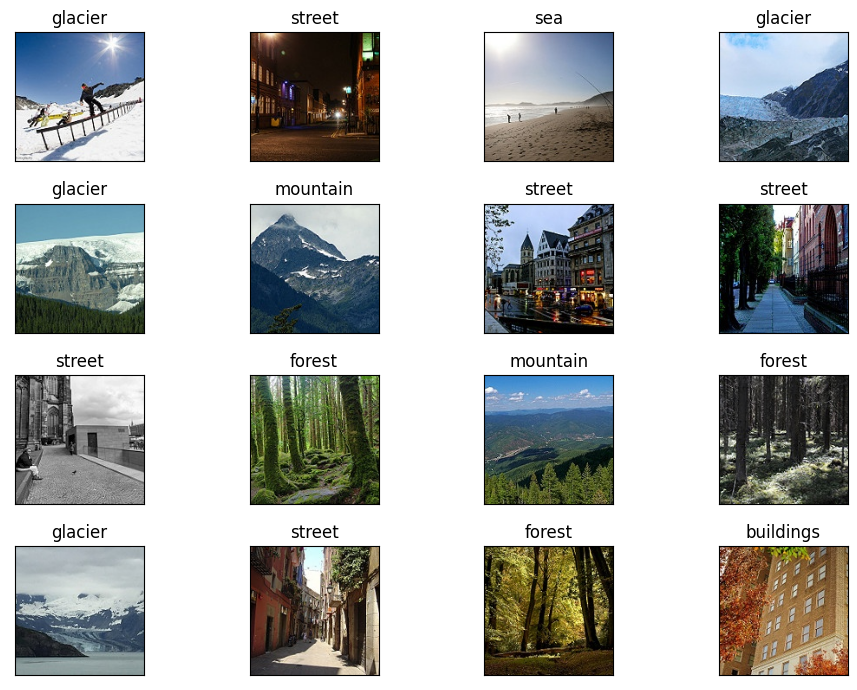

In [7]:
# vẽ các ảnh tương ứng với label
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

In [8]:
data.Labels.value_counts()

mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
Name: Labels, dtype: int64

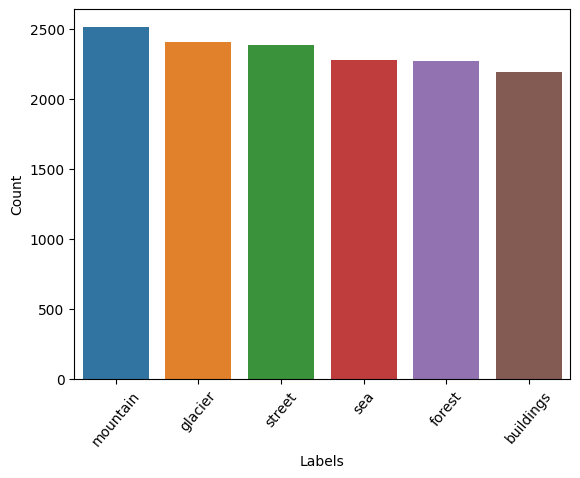

In [9]:
# Thống kê số lượng ảnh cho từng label 
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [10]:
batch_size = 32
img_height = 112
img_width = 112

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory= os.path.join(SCENES_CLASSIFICATION_PATH, 'train'),
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.


2022-12-29 13:16:56.904692: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 13:16:56.905116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 13:16:56.905219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 13:16:56.905264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=os.path.join(SCENES_CLASSIFICATION_PATH, 'val'),
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.


In [13]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


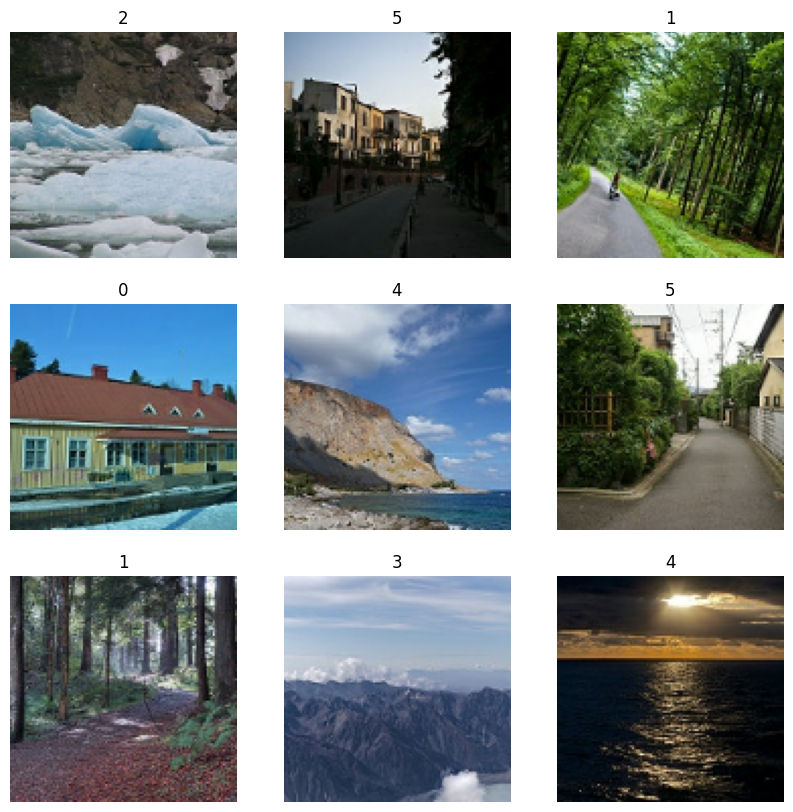

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(scale=1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)
                                        , fill_mode='nearest'),
])

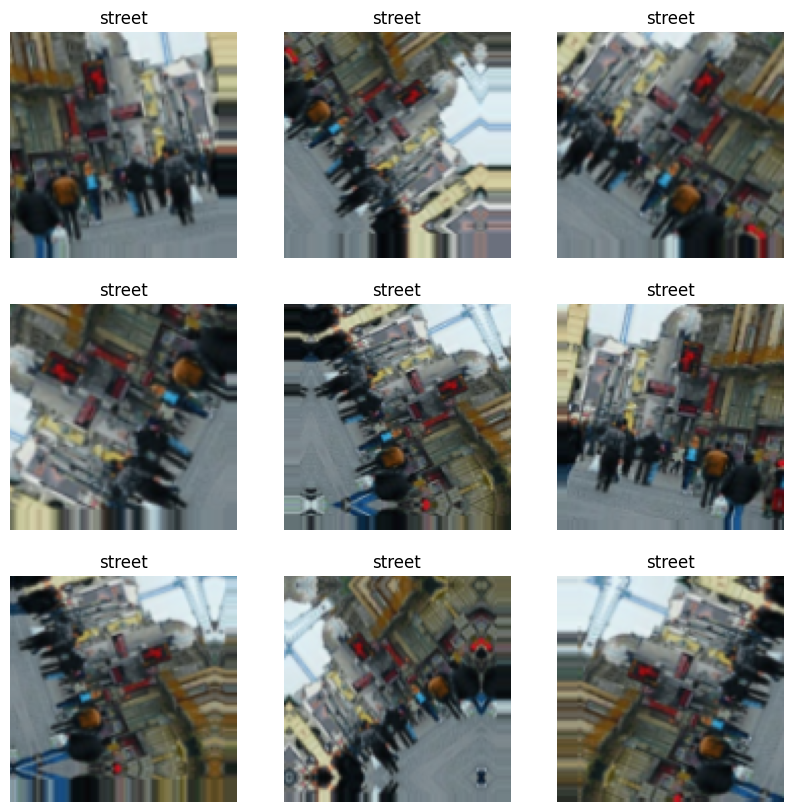

In [16]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(np.expand_dims(images[0].numpy(),axis=0).astype("uint8"))[0])
    plt.title(class_names[labels[0]])
    plt.axis("off")

## ResNet34_V2 (skip connection: Add)

In [17]:
class BuildResNet34_v2():
    def __init__(self):
        pass
    
    
    def identity_block(self, inputs, filters):
        x = layers.BatchNormalization()(inputs)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        
        return layers.add([inputs, x])
            
        
    
    def projection_block(self, inputs, filters):
        x = layers.BatchNormalization()(inputs)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=2, use_bias=False)(x)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        
        
        shortcut = layers.BatchNormalization()(inputs)
        shortcut = layers.Activation('relu')(shortcut)
        shortcut = layers.Conv2D(filters=filters, kernel_size=(1,1), padding='same', 
                             strides=2, use_bias=False)(shortcut)
        return layers.add([shortcut,x])
    

    def build_model(self, classes, input_shape=(224,224,3)):
        inputs = layers.Input(shape=input_shape)
        x = layers.ZeroPadding2D(padding=(3,3))(inputs)
        x = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, use_bias=False)(x)
        x = layers.ZeroPadding2D(padding=(1,1))(x)
        x = layers.MaxPooling2D(pool_size=(3,3), strides=2)(x)
        
        # conv2_X
        x = self.identity_block(x, filters=64)
        x = self.identity_block(x, filters=64)
        x = self.identity_block(x, filters=64)
        
        # conv3_x
        x = self.projection_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        
        # conv4_x
        x = self.projection_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        
        # conv5_x
        x = self.projection_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.GlobalAveragePooling2D()(x)
        outputs = layers.Dense(classes, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=outputs)
        
        return model

In [18]:
build_resnet34_v2 = BuildResNet34_v2()
resnet34_v2_model_add = build_resnet34_v2.build_model(input_shape=(img_height, img_width, 3), classes=6)

image_input = layers.Input(shape=(img_height,img_width,3))
x = data_augmentation(image_input)
x = resnet34_v2_model_add(x)
scenes_classification_resnet34_v2_model_add = Model(inputs=image_input, outputs=x)

scenes_classification_resnet34_v2_model_add.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, 3)       0         
                                                                 
 model (Functional)          (None, 6)                 21302982  
                                                                 
Total params: 21,302,982
Trainable params: 21,286,854
Non-trainable params: 16,128
_________________________________________________________________


In [19]:
num_epochs = 100

scenes_classification_resnet34_v2_model_add.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


history = scenes_classification_resnet34_v2_model_add.fit(train_ds,
                                epochs = num_epochs,
                                validation_data = val_ds)

Epoch 1/100


2022-12-29 13:17:01.410116: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-12-29 13:17:02.739299: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


439/439 [==============================] - 24s 45ms/step - loss: 1.1677 - accuracy: 0.5475 - val_loss: 1.2757 - val_accuracy: 0.5607
Epoch 2/100
439/439 [==============================] - 19s 44ms/step - loss: 0.9674 - accuracy: 0.6337 - val_loss: 1.4943 - val_accuracy: 0.5123
Epoch 3/100
439/439 [==============================] - 19s 43ms/step - loss: 0.8845 - accuracy: 0.6643 - val_loss: 1.2907 - val_accuracy: 0.5813
Epoch 4/100
439/439 [==============================] - 19s 44ms/step - loss: 0.8383 - accuracy: 0.6899 - val_loss: 0.9077 - val_accuracy: 0.6687
Epoch 5/100
439/439 [==============================] - 19s 44ms/step - loss: 0.7843 - accuracy: 0.7060 - val_loss: 1.1546 - val_accuracy: 0.6077
Epoch 6/100
439/439 [==============================] - 19s 44ms/step - loss: 0.7636 - accuracy: 0.7170 - val_loss: 0.9068 - val_accuracy: 0.6743
Epoch 7/100
439/439 [==============================] - 19s 44ms/step - loss: 0.7322 - accuracy: 0.7319 - val_loss: 1.1603 - val_accuracy: 0.61

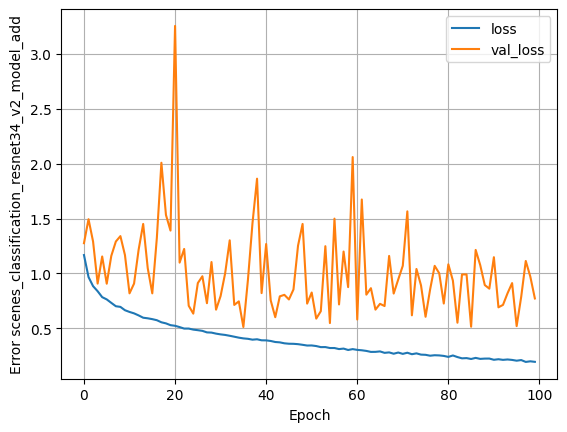

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error scenes_classification_resnet34_v2_model_add')
plt.legend()
plt.grid(True)

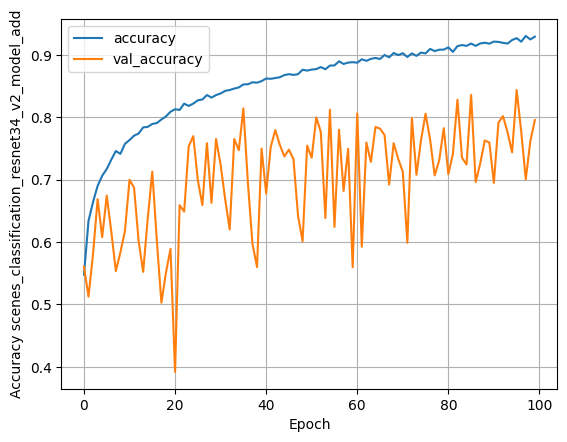

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy scenes_classification_resnet34_v2_model_add')
plt.legend()
plt.grid(True)

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,0.205461,0.926607,0.520419,0.843667,95
96,0.211172,0.920978,0.787688,0.777000,96
97,0.194287,0.930241,1.113985,0.700333,97
98,0.199939,0.924612,0.971300,0.761333,98
99,0.194996,0.929030,0.772236,0.795333,99
